# Import Statements

In [1]:
import os
import logging
logging.basicConfig(level=logging.INFO)
import warnings
warnings.filterwarnings('ignore')

import geodata
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle

import geoplot
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as mcbar
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Load coarsened datasets

In [2]:
os.chdir('../data/pickle')

# includes LCOE
file = open("xarray_ds_wind.pickle",'rb')
xarray_ds_wind = pickle.load(file)
file.close()
file = open("xarray_ds_solar.pickle",'rb')
xarray_ds_solar = pickle.load(file)
file.close()
# state shapes
file = open("states.pickle",'rb')
states = pickle.load(file)
file.close()

# Convert to Mask Resolution

In [3]:
def reindex(ds, target):
    
    return ds.reindex_like(target, method = 'nearest')

def ds_reformat_index(ds):
	"""format the dataArray generated from the convert function"""
	if 'lat' in ds.dims and 'lon' in ds.dims:
		return ds.sortby(['lat', 'lon'])
	elif 'lat' in ds.coords and 'lon' in ds.coords:
		return ds.reset_coords(['lon', 'lat'], drop = True).rename({'x': 'lon', 'y': 'lat'}).sortby(['lat', 'lon'])
	else:
		return ds.rename({'x': 'lon', 'y': 'lat'}).sortby(['lat', 'lon'])
    
os.chdir('../masks')
mask = ds_reformat_index(xr.open_rasterio("MODIS_INDIA_SOLAR.tif"))

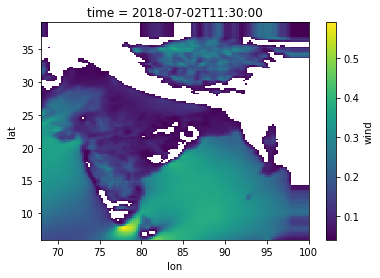

In [4]:
xarray_ds_wind = reindex(xarray_ds_wind, mask)
xarray_ds_wind['wind'].plot()

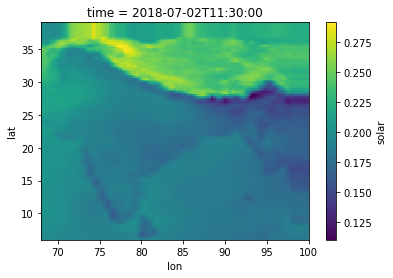

In [5]:
xarray_ds_solar = reindex(xarray_ds_solar, mask)
xarray_ds_solar['solar'].plot()

# Add mask DataArray Variable

In [6]:
solar_mask_path = os.path.join(geodata.config.mask_dir,
                               'India Solar All', #these are the right mask right?
                               'merged_mask', 
                               'merged_mask.tif')
wind_mask_path = os.path.join(geodata.config.mask_dir,
                               'India Wind All', 
                              'merged_mask', 
                              'merged_mask.tif')

In [7]:
solar_mask = ds_reformat_index(xr.open_rasterio(solar_mask_path))
wind_mask = ds_reformat_index(xr.open_rasterio(wind_mask_path))

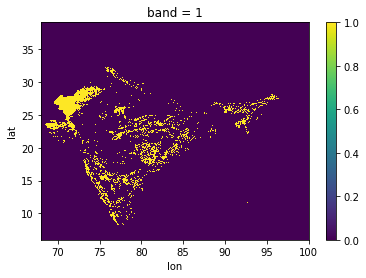

In [8]:
solar_mask.plot()

In [9]:
xarray_ds_solar['mask'] = xr.DataArray(solar_mask.values, coords={
                            'time': xarray_ds_solar['time'].values,
                            'lat': xarray_ds_solar['lat'].values, 
                            'lon': xarray_ds_solar['lon'].values, 
                        },
             dims=['time', 'lat', 'lon'])

In [10]:
xarray_ds_wind['mask'] = xr.DataArray(wind_mask.values, coords={
                            'time': xarray_ds_wind['time'].values,
                            'lat': xarray_ds_wind['lat'].values, 
                            'lon': xarray_ds_wind['lon'].values, 
                        },
             dims=['time', 'lat', 'lon'])

# Export High Resolution Figures

In [11]:
# os.chdir('../pickle')
# # export to pickle
# filehandler = open("xarray_ds_solar_mask_resolution.pickle","wb")
# pickle.dump(xarray_ds_solar, filehandler)
# filehandler.close()
# filehandler = open("xarray_ds_wind_mask_resolution.pickle","wb")
# pickle.dump(xarray_ds_wind, filehandler)
# filehandler.close()

# CF/LCOE Plots: All India

In [12]:
# os.chdir('../pickle')

# # includes LCOE
# file = open("xarray_ds_solar_mask_resolution.pickle",'rb')
# xarray_ds_solar = pickle.load(file)
# file.close()
# file = open("xarray_ds_wind_mask_resolution.pickle",'rb')
# xarray_ds_wind = pickle.load(file)
# file.close()

In [13]:
os.chdir('../../outputs/plots')

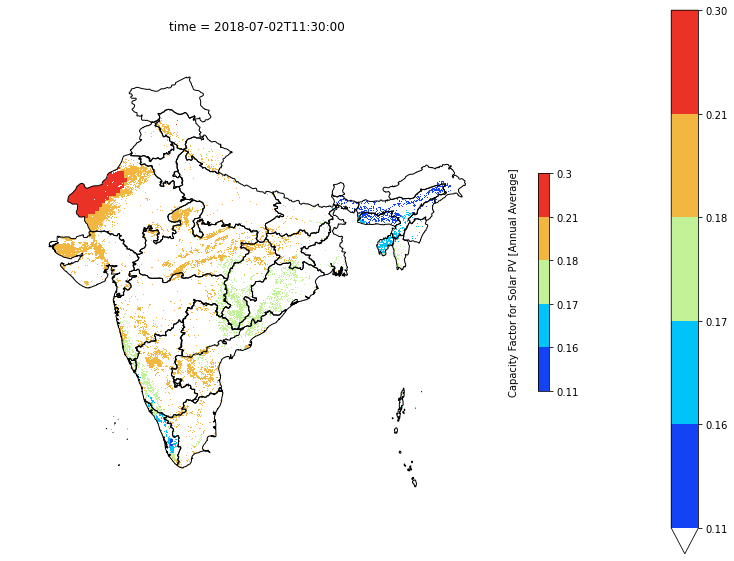

In [14]:
out = xarray_ds_solar['solar'] * xarray_ds_solar['mask']

col_dict = {
    0: 'white',
    1: "#1343f4",
    2: "#00c3f9",
    3: "#c1f298",
    4: "#f2b740",
    5: "#ea3326",
}

cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
cm1 = ListedColormap([col_dict[x] for x in range(1,6)])

labels = np.array(['0.11 - 0.16', '0.16 - 0.17', '0.17 - 0.18', '0.18 - 0.21', '0.21 - 0.29'])
norm_bins = [0.11, 0.16, 0.17, 0.18, 0.21, 0.3]
norm = matplotlib.colors.BoundaryNorm(norm_bins, len(labels))

fig = plt.figure(figsize = (14, 10))
ax = fig.add_subplot()

a = out.plot(
    ax=ax,
    cmap=cm,
    norm=norm,
    zorder=-1
)

b = geoplot.polyplot(
    gpd.GeoSeries(states),
    ax=ax
)

cax, cbar_kwds = mcbar.make_axes(ax, location = 'right', fraction=0.15, shrink=0.4, aspect=20)
cb = matplotlib.colorbar.ColorbarBase(cax, 
                                      cmap=cm1,
                                      norm=norm,
                                      ticks=norm_bins,
                                      spacing='uniform'
)
cb.set_ticklabels(norm_bins)
cb.set_label("Capacity Factor for Solar PV [Annual Average]", labelpad=-70)

ax.get_figure().savefig("solar_cf_suitability_mask.png")

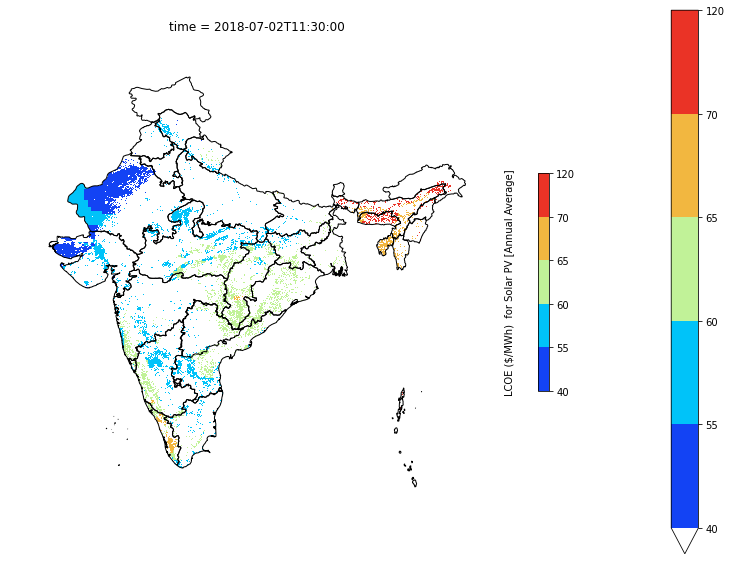

In [15]:
out = xarray_ds_solar['LCOE ($/MWh) mid'] * xarray_ds_solar['mask']

labels = np.array(['40 - 55', '55 - 60', '60 - 65', '65 - 70', '70+'])
norm_bins = [40, 55, 60, 65, 70, 120]
norm = matplotlib.colors.BoundaryNorm(norm_bins, len(labels))

fig = plt.figure(figsize = (14, 10))
ax = fig.add_subplot()

a = out.plot(
    ax=ax,
    cmap=cm,
    norm=norm,
    zorder=-1
)

b = geoplot.polyplot(
    gpd.GeoSeries(states),
    ax=ax
)

cax, cbar_kwds = mcbar.make_axes(ax, location = 'right', fraction=0.15, shrink=0.4, aspect=20)
cb = matplotlib.colorbar.ColorbarBase(cax, 
                                      cmap=cm1,
                                      norm=norm,
                                      ticks=norm_bins,
                                      spacing='uniform'
)
cb.set_ticklabels(norm_bins)
cb.set_label("LCOE ($/MWh)  for Solar PV [Annual Average]", labelpad=-70)

ax.get_figure().savefig("solar_lcoe_suitability_mask.png")

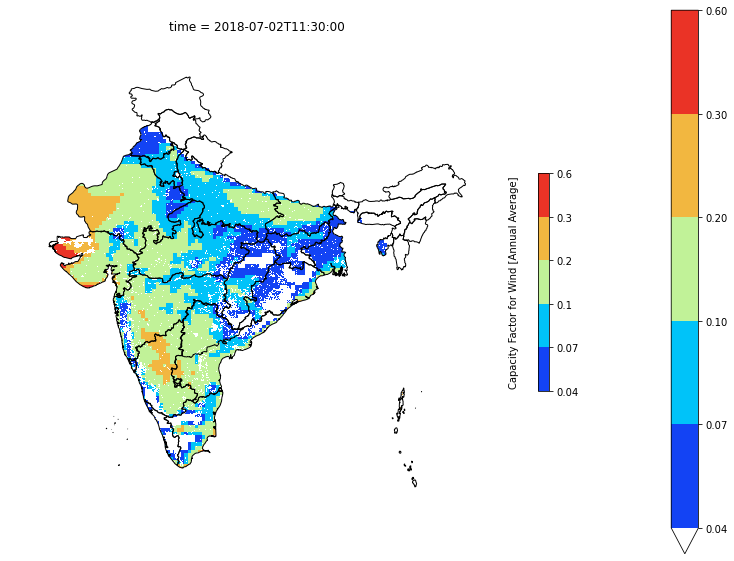

In [16]:
out = xarray_ds_wind['wind'] * xarray_ds_wind['mask']

labels = np.array(['0.04 - 0.07', '0.07 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3-0.5'])
norm_bins = [0.04, 0.07, 0.1, 0.2, 0.3, 0.6]
norm = matplotlib.colors.BoundaryNorm(norm_bins, len(labels))

fig = plt.figure(figsize = (14, 10))
ax = fig.add_subplot()

a = out.plot(
    ax=ax,
    cmap=cm,
    norm=norm,
    zorder=-1
)

b = geoplot.polyplot(
    gpd.GeoSeries(states),
    ax=ax
)

cax, cbar_kwds = mcbar.make_axes(ax, location = 'right', fraction=0.15, shrink=0.4, aspect=20)
cb = matplotlib.colorbar.ColorbarBase(cax, 
                                      cmap=cm1,
                                      norm=norm,
                                      ticks=norm_bins,
                                      spacing='uniform'
)
cb.set_ticklabels(norm_bins)
cb.set_label("Capacity Factor for Wind [Annual Average]", labelpad=-70)

ax.get_figure().savefig("wind_cf_suitability_mask.png")

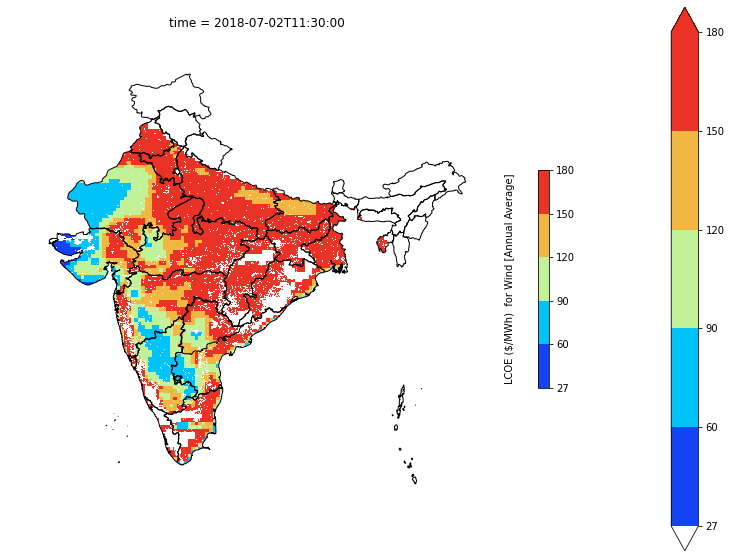

In [17]:
out = xarray_ds_wind['LCOE ($/MWh) mid'] * xarray_ds_wind['mask']

labels = np.array(['30 - 60', '60 - 90', '90 - 120', '120 - 150', '150+'])
norm_bins = [27, 60, 90, 120, 150, 180]
norm = matplotlib.colors.BoundaryNorm(norm_bins, len(labels))

fig = plt.figure(figsize = (14, 10))
ax = fig.add_subplot()

a = out.plot(
    ax=ax,
    cmap=cm,
    norm=norm,
    zorder=-1
)

b = geoplot.polyplot(
    gpd.GeoSeries(states),
    ax=ax
)

cax, cbar_kwds = mcbar.make_axes(ax, location = 'right', fraction=0.15, shrink=0.4, aspect=20)
cb = matplotlib.colorbar.ColorbarBase(cax, 
                                      cmap=cm1,
                                      norm=norm,
                                      ticks=norm_bins,
                                      spacing='uniform'
)
cb.set_ticklabels(norm_bins)
cb.set_label("LCOE ($/MWh)  for Wind [Annual Average]", labelpad=-70)

ax.get_figure().savefig("wind_lcoe_suitability_mask.png")